In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pylab as plt 
from getdist import plots, MCSamples
from utils.helpers import pickle_load, pickle_save

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878' #'#B5CA8D'
color2 = '#222E50'
alpha = 0.5
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

# CAMB

In [2]:
camb_1 = pickle_load('src/emulike/planck/samples', 'samples_lcdm_CAMB_experiment_1')  
camb_samples_1 = camb_1.get_chain(flat=True, thin = 2, discard = 1000)

In [21]:
gp_1 = pickle_load('src/emulike/planck/samples', 'samples_lcdm_GP_1500_testing')
gp_samples_1 = gp_1.get_chain(flat=True, thin = 2, discard = 1000)

In [23]:
np.mean(gp_samples_1, 0)

array([0.02234505, 0.12033329, 0.67190734, 3.04340328, 0.96469559])

In [24]:
np.std(gp_samples_1, 0)

array([0.0001423 , 0.00130033, 0.00575726, 0.00362576, 0.00408533])

In [25]:
np.mean(camb_samples_1, 0)

array([0.02235152, 0.12025249, 0.67225406, 3.04324051, 0.96501709])

In [26]:
np.std(camb_samples_1, 0)

array([0.00014286, 0.00127224, 0.00561557, 0.0035083 , 0.00406829])

In [27]:
NDIM = camb_samples_1.shape[1]
names = ["x%s"%i for i in range(NDIM)]
labels = [r'$\Omega_{b}h^{2}$', 
          r'$\Omega_{cdm}h^{2}$', 
          r'$h$', 
          r'$ln(10^{10}A_{s})$', 
          r'$n_{s}$']

samples_1 = MCSamples(samples=camb_samples_1,names = names, labels = labels, settings = settings, label = 'CAMB')
samples_2 = MCSamples(samples=gp_samples_1,names = names, labels = labels, settings = settings, label = 'Emulator')

Removed no burn in
Removed no burn in


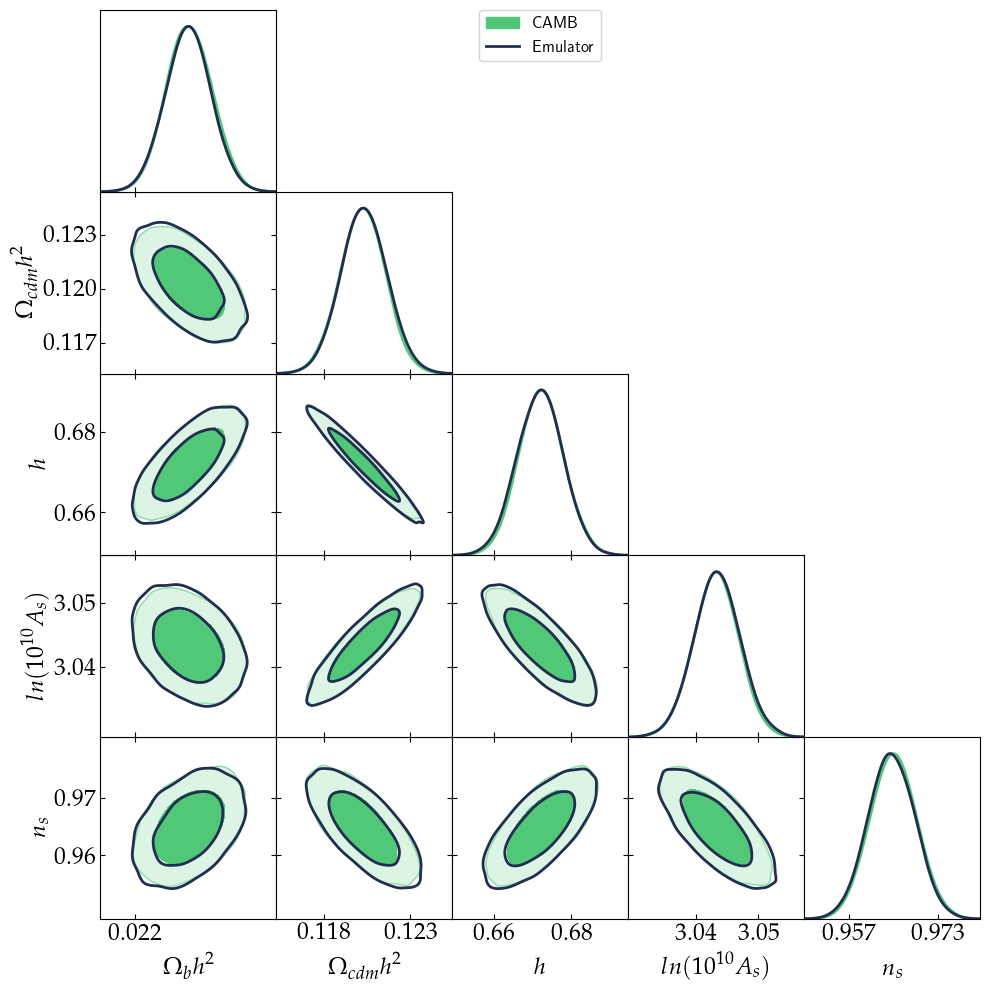

In [28]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True, False], contour_colors=[color1, color2], contour_lws=[2,2], contour_ls=['-','-'])
# plt.savefig('plots/triangle_plot_uniform_accurate.pdf', transparent = False, bbox_inches = 'tight') 
# plt.savefig('plots/triangle_plot_uniform_accurate.png', transparent = False, bbox_inches = 'tight') 
plt.show()